# Tache de generation de titre pour des articles. 

The dataset for Title Generation comprises a collection of articles along with their corresponding titles and subjects. Each entry in the dataset includes the full text of an article, its subject category, and the title that summarizes its content. This batchset serves as a valuable resource for natural language processing tasks, particularly in the domain of text summarization and headline generation. Researchers, developers, and enthusiasts can leverage this batchset to train machine learning models for automatic title generation, headline summarization, and related applications. With a diverse range of subjects and article texts, this batchset offers ample opportunities for experimentation and innovation in the field of natural language processing.

link : https://www.kaggle.com/datasets/thejas2002/titlegen

## Chargement des modules, des données et visualisations

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import re
import tqdm 
from datetime import datetime 
from pathlib import Path
import kagglehub

from sklearn.model_selection import train_test_split

from IPython.display import display, HTML
from pandas import DataFrame

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

from datasets import Dataset

# Importing the T5 modules from huggingface/transformers
from transformers import AutoTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer


from torch import cuda



# link nootbooks associated : 
# https://www.kaggle.com/code/thejas2002/title-generation
# https://www.kaggle.com/code/a3amat02/news-title-generation-using-t5

# https://medium.com/nlplanet/a-full-guide-to-finetuning-t5-for-text2text-and-building-a-demo-with-streamlit-c72009631887
# https://learnopencv.com/fine-tuning-t5/
# https://github.com/Shivanandroy/T5-Finetuning-PyTorch


## Configuration

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'

SEED = 0              # random seed 

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(SEED) # pytorch random seed
np.random.seed(SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

MAX_LEN_TEXT = 500
MAX_LEN_TITLE = 45
MIN_LEN_TITLE = 3

MODEL_TYPE = "t5"
MODEL_NAME = "t5-small"

NUM_PROCS = os.cpu_count() #print(NUM_PROCS)

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 6

NUM_BEAMS=4

LEARNING_RATE = 1e-4

NB_EPOCHS = 15



In [3]:
os.makedirs("../data/titlegen",exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("thejas2002/titlegen",force_download=True)

for dirname, _, filenames in os.walk(path):
    print(dirname)
    print(_)
    print(filenames)
    for filename in filenames:
        Path(os.path.join(dirname, filename)).rename(os.path.join("../data/titlegen", filename))

100%|██████████| 13.3M/13.3M [00:00<00:00, 31.3MB/s]

Extracting files...


/home/ivanhoe/.cache/kagglehub/datasets/thejas2002/titlegen/versions/2
[]
['train.csv', 'test.csv']


In [4]:
! file "../data/titlegen/train.csv"

../data/titlegen/train.csv: CSV Unicode text, UTF-8 text


In [3]:
path_df = os.path.join("../data/titlegen", "train.csv")

encoding='utf-8'

# Load training batch
try:
    df = pd.read_csv(path_df,encoding=encoding)
    df.dropna(inplace=True)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading Dataset: {e}")

#Avoir moins de données - A commenter par la suite
#df = df.sample(int(df.shape[0]*0.2))

train_df, test_df = train_test_split(df, test_size=0.2,random_state=0)
eval_df, test_df = train_test_split(test_df, test_size=0.5,random_state=0)

print(train_df.info())
print(eval_df.info())
print(test_df.info())


Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 11992 entries, 3019 to 2732
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    11992 non-null  object
 1   text     11992 non-null  object
 2   subject  11992 non-null  object
 3   date     11992 non-null  object
dtypes: object(4)
memory usage: 468.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1499 entries, 2214 to 5741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1499 non-null   object
 1   text     1499 non-null   object
 2   subject  1499 non-null   object
 3   date     1499 non-null   object
dtypes: object(4)
memory usage: 58.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 2201 to 14849
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1500 non-null   object
 1   text

In [6]:


def display_random_sample(dataset:DataFrame, num_examples:int=1)->None:

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset." # A way to raise an error if it's not true
    sample_df = dataset.sample(num_examples)

    display(HTML(sample_df.to_html()))

display_random_sample(train_df,3) 

,title,text,subject,date
9209,Marco Rubio emerges as champion of battered Republican establishment,"DES MOINES (Reuters) - Texas Senator Ted Cruz was victorious in the first Republican nomination contest of the 2016 White House race, but there was another big winner in Iowa on Monday night: Florida Senator Marco Rubio and the Republican establishment. For months, Cruz and Donald Trump’s brand of angry, scorched-earth, insurgent politics defined the race for the Republican presidential nomination, while more moderate candidates tussled with themselves to try to mount a challenge to them. The hope among Republican party leaders has long been for a champion to emerge. And on Monday, that person was Rubio, who finished a hair behind Trump and only a few points behind Cruz. When Rubio took the stage in a hotel ballroom after the final results were announced, he gave what amounted to a victory speech. “This is the moment they said would never happen,” the first-term senator said. “For months, they told us we had no chance.” The fight for the nomination has unmistakably entered a new phase. “We have a three-way race,” said Craig Robinson, the former political director of the Iowa Republican Party. Rubio’s night shocked Iowa political observers like Robinson, who had predicted Rubio would wind up far behind Trump and Cruz, with perhaps around 15-18 percent of the vote. He finished with 23 percent. Rubio’s performance will strengthen his argument that supporters of other moderate, establishment candidates such as former Florida Governor Jeb Bush, New Jersey Governor Chris Christie, and Ohio governor John Kasich should throw their support, and their money, behind him. Rubio could use the extra cash. His campaign committee raised just over $14 million from donors in the fourth quarter of 2015, putting him well behind Cruz, who brought in more than $20 million. To date, his campaign has raised nearly $40 million, while Cruz has raised $47 million. Rubio’s Super PAC, which can raise unlimited funds as long as it does not coordinate directly with him, also trails the PACs supporting Cruz. It pulled in $30.5 million last year, while Cruz’s PACs raked in $42 million. Trump, a billionaire, largely self-funds his campaign. Rubio’s third place finish in Iowa means he “is the consensus establishment candidate,” said Douglas Gross, a Republican strategist in Des Moines. Rubio flew to New Hampshire on Monday evening and will likely begin making that argument to voters there ahead of the state’s primary, or early nominating contest, on Feb. 10. On the campaign trail in Iowa, Rubio railed at many of the same targets as Cruz and Trump: Islamic State, immigration and President Barack Obama’s healthcare overhaul, popularly known as Obamacare. But he embedded his criticism within a more optimistic, inclusive message. The American-born son of Cuban immigrants, Rubio would be the first Hispanic president. “It’s not enough to just be angry,” Rubio told voters during last-minute campaigning in the weekend before the caucus vote. “Anger is not a plan. Anger is not solution.” Iowans who supported Rubio at the caucuses told Reuters they responded to his positive message and viewed him as the best candidate to beat Hillary Clinton in the November election, should she be the Democratic nominee. “I’ve been looking for someone who really will be an agent for change and I think Marco Rubio will be that guy,” said Kevin Huerkamp, 56, of Clive, Iowa. According to election returns, Rubio swamped both Cruz and Trump in Iowa’s urban areas - Des Moines, Iowa City, Davenport -suggesting that he could prosper when the Republican race progresses to denser, more populated states such as Florida and Ohio. (This story has been refiled to replace Rubio’s name in last paragraph with Trump’s)",politicsNews,"February 2, 2016"
11823,FBI probes hacks targeting phones of Democratic Party officials: sources,"WASHINGTON (Reuters) - The FBI is investigating suspected attempts to hack mob

# Environment configuration and data manipulation

## Load tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,clean_up_tokenization_spaces=True,legacy=False)

In [16]:

print(tokenizer.vocab_size)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.eos_token,tokenizer.eos_token_id)


text = """BRUSSELS/KIEV (Reuters)
 - Ukraine s EU membership ambitions will collide with the West s reform demands at a summit on Friday with EU
 leaders ready to admonish Kiev for failing to implement anti-corruption laws that would bring it closer to the West,
   officials say. url : http://univangers  caractères spéciaux : $=)&)ç,à_ué  balise html :<p>EU membership ambitions<p/> 
"""

print(tokenizer.backend_tokenizer.normalizer.normalize_str(text))

print(tokenizer.tokenize(text))

source = tokenizer(text,return_tensors='pt')




32100
<pad> 0
</s> 1
BRUSSELS/KIEV (Reuters)  - Ukraine s EU membership ambitions will collide with the West s reform demands at a summit on Friday with EU  leaders ready to admonish Kiev for failing to implement anti-corruption laws that would bring it closer to the West,    officials say. url : http://univangers  caractères spéciaux : $=)&)ç,à_ué  balise html :<p>EU membership ambitions<p/>  
['▁', 'BR', 'US', 'SEL', 'S', '/', 'KI', 'EV', '▁(', 'Reuters', ')', '▁', '-', '▁Ukraine', '▁', 's', '▁EU', '▁membership', '▁ambition', 's', '▁will', '▁coll', 'ide', '▁with', '▁the', '▁West', '▁', 's', '▁reform', '▁demands', '▁at', '▁', 'a', '▁summit', '▁on', '▁Friday', '▁with', '▁EU', '▁leaders', '▁ready', '▁to', '▁', 'a', 'd', 'mon', 'ish', '▁Kiev', '▁for', '▁failing', '▁to', '▁implement', '▁anti', '-', 'co', 'rruption', '▁laws', '▁that', '▁would', '▁bring', '▁it', '▁closer', '▁to', '▁the', '▁West', ',', '▁officials', '▁say', '.', '▁', 'url', '▁', ':', '▁http', '://', 'un', 'iva', 'nger', 's',

In [17]:
source = tokenizer(text,return_tensors='pt')
print(source["input_ids"].squeeze(),source["attention_mask"].squeeze())

tensor([    3,  6934,  3063, 23143,   134,    87, 14108,  8878,    41, 18844,
           61,     3,    18, 11897,     3,     7,  3371,  4757, 12517,     7,
           56,  8029,  1599,    28,     8,  1244,     3,     7,  5139,  7328,
           44,     3,     9, 13385,    30,  1701,    28,  3371,  2440,  1065,
           12,     3,     9,    26,  2157,  1273, 30713,    21, 12385,    12,
         4028,  1181,    18,   509, 27599,  3786,    24,   133,   830,    34,
         4645,    12,     8,  1244,     6,  4298,   497,     5,     3, 16137,
            3,    10,  2649,  1303,   202,  6823,  9369,     7, 17973,     7,
        28301,  1724,     3,    10,  1514,  2423,    61,   184,    61,  8970,
            6,    85,   834,    76,   154,  6561,   159,    15,     3, 10500,
            3,    10,     2,   102,  3155, 12062,  4757, 12517,     7,     2,
          102,    87,  3155,     1]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1,

Détails de l'expression régulière :

^ : L'accent circonflexe signifie le début de la ligne ou de la chaîne de caractères.

. : Cela représente n'importe quel caractère (sauf les sauts de ligne).
flags=re.DOTALL : Le paramètre flags=re.DOTALL permet à l'opérateur . de correspondre à n'importe quel caractère, y compris les sauts de ligne

\* : Cela signifie "0 ou plusieurs occurrences" du caractère précédent (ici, n'importe quel caractère).

? : C'est un modificateur appelé "lazy matching" ou "non-greedy". Cela signifie qu'il va capturer le minimum possible de caractères, contrairement à un quantificateur * sans ? qui capte le maximum possible.

In [18]:
import re   

def clean_text(text):
   
   # Remove any text before and including a hyphen followed by a space
   text = re.sub(r'^.*?- ', '', text, flags=re.DOTALL) 

   # Remove URLs (e.g., "Visit https://example.com" -> "Visit")
   text = re.sub(r'https?://\S+|www\.\S+', '', text)

   # Remove HTML tags (e.g., "<p>text</p>" -> "text")
   text = re.sub(r'<.*?>+', '', text)

   #Remove extra space
   text = ' '.join(text.split())

   # Remove newline characters (e.g., "text\nmore text" -> "text more text")
   text = re.sub(r'\n', '', text)

   return text

# Example usage of the function
result = clean_text(text)

print(result)  

Ukraine s EU membership ambitions will collide with the West s reform demands at a summit on Friday with EU leaders ready to admonish Kiev for failing to implement anti-corruption laws that would bring it closer to the West, officials say. url : caractères spéciaux : $=)&)ç,à_ué balise html :EU membership ambitions


Ajout d'un contexte : "Generate a title: " pour effectuer une demande spécifique au modèle T5 

In [10]:
train_df["text"] = "Generate a title: " + train_df["text"].apply(clean_text)
eval_df["text"] = "Generate a title: "  + eval_df["text"].apply(clean_text)
test_df["text"] = "Generate a title: " + test_df["text"].apply(clean_text)

train_df = train_df[["text","title"]]

eval_df = eval_df[["text","title"]]

test_df = test_df[["text","title"]]

In [11]:
display_random_sample(train_df,3) 

## Visualisation du nombre de tokens par text/title

In [12]:
text_input_ids_train = train_df["text"].apply(lambda text : len(tokenizer(text, truncation=False,return_tensors='pt')["input_ids"].squeeze()) )

title_input_ids_train = train_df["title"].apply(lambda title : len(tokenizer(title, truncation=False,return_tensors='pt')["input_ids"].squeeze()) )

Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 512). Running this sequence through the model will result in indexing errors


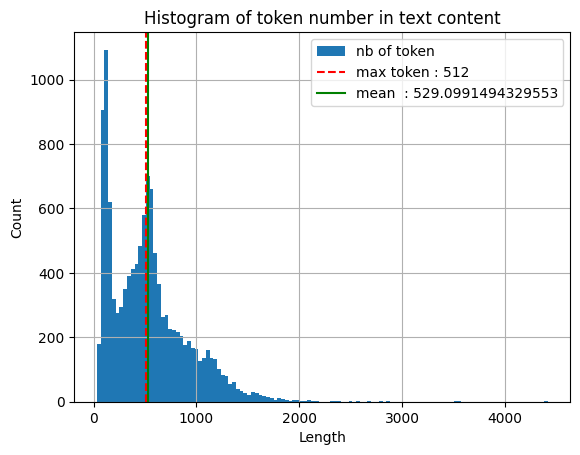

0.46631087391594395 % des texts avec plus de 512 tokens


In [13]:
text_input_ids_train.hist(bins=120,label='nb of token')

# Add a vertical line at x=512 with red color
plt.axvline(x=512, color='r', linestyle='--', label='max token : 512')
plt.axvline(x=text_input_ids_train.mean(), color='g', linestyle='-', label=f'mean  : {text_input_ids_train.mean()}')

# Adding title and labels 
plt.title('Histogram of token number in text content') 
plt.xlabel('Length') 
plt.ylabel('Count') 
plt.legend()
  
# Display the histogram 
plt.show() 

print(f"{text_input_ids_train[text_input_ids_train > 512].count()/text_input_ids_train.count()} % des texts avec plus de 512 tokens")

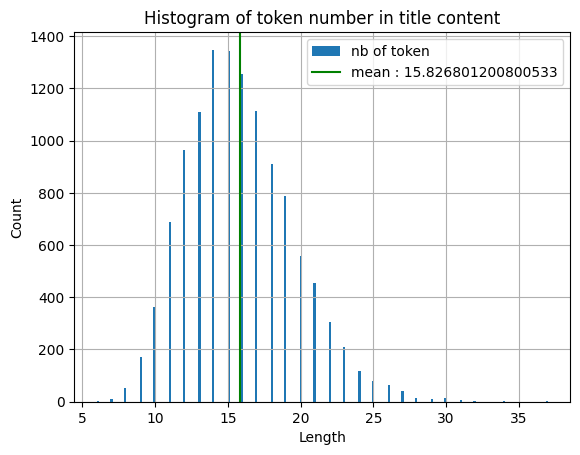

In [14]:
title_input_ids_train.hist(bins=200,label='nb of token')

# Add a vertical line at x=512 with red color
plt.axvline(x=title_input_ids_train.mean() , color='g', linestyle='-', label=f'mean : {title_input_ids_train.mean()}')

# Adding title and labels 
plt.title('Histogram of token number in title content') 
plt.xlabel('Length') 
plt.ylabel('Count') 
plt.legend()
  
# Display the histogram 
plt.show() 


## Dataset Pipeline preprocessing

In [15]:
# Define a function for tokenization
def tokenize_function(example,truncation=True):

    source = tokenizer(text=example["text"], truncation=truncation, max_length=MAX_LEN_TEXT, return_tensors='pt')
    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    
   
    target = tokenizer(text_target=example["title"], truncation=truncation, max_length=MAX_LEN_TITLE, return_tensors='pt')
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'input_ids': source_ids, 
        'attention_mask': source_mask,
        'labels': target_ids, 
        'labels_mask': target_mask
        }

In [16]:
#transforme a pandas df to a torch dataset object 
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)


In [17]:
train_dataset = train_dataset.map(tokenize_function,num_proc=NUM_PROCS)
eval_dataset = eval_dataset.map(tokenize_function,num_proc=NUM_PROCS)
test_dataset = test_dataset.map(tokenize_function,num_proc=NUM_PROCS)


Map (num_proc=12):   0%|          | 0/11992 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/1499 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/1500 [00:00<?, ? examples/s]

In [18]:
# Define the custom collate function
def collate_fn(batch,tokenizer=tokenizer):
    """
    Custom collate function that add padding for each batch.
    """

    #load text
    #texts = [item['text']for item in batch]

    # Pad the tokenized content
    padded_text_ids = pad_sequence(
        [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)
    
    padded_text_mask = pad_sequence(
        [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=0)

    padded_title_ids = pad_sequence(
        [torch.tensor(item['labels'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id) 
    #Ajouter le token de Padding au début
    
    
    padded_title_mask = pad_sequence(
        [torch.tensor(item['labels_mask'], 
                      dtype=torch.long) for item in batch], 
                      batch_first=True, 
                      padding_value=0)
    #padded_title_mask = torch.cat((torch.ones((padded_title_mask.size(0), 1), dtype=torch.long), padded_title_mask), dim=1)
    

    return {
        'input_ids':padded_text_ids,
        'attention_mask':padded_text_mask,
        'labels':padded_title_ids,
        'labels_mask':padded_title_mask
    }


In [19]:

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

val_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

# This will be used down for training and validation stage for the model.
train_loader = DataLoader(train_dataset, **train_params)
eval_loader = DataLoader(eval_dataset, **val_params)
test_loader = DataLoader(test_dataset, **val_params)

In [20]:
for batch in train_loader:
    for key in batch.keys():
        print(key)
        print(batch[key].shape)

    break

for batch in eval_loader:
    for key in batch.keys():
        print(batch[key])
    break

input_ids
torch.Size([4, 500])
attention_mask
torch.Size([4, 500])
labels
torch.Size([4, 17])
labels_mask
torch.Size([4, 17])
tensor([[6939, 2206,    3,  ...,    0,    0,    0],
        [6939, 2206,    3,  ...,    0,    0,    0],
        [6939, 2206,    3,  ..., 1117, 7054,    1],
        [6939, 2206,    3,  ...,    0,    0,    0],
        [6939, 2206,    3,  ...,    0,    0,    0],
        [6939, 2206,    3,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[ 2830,   769, 12908,     7,    44, 10155,    29,  2147,    21,   511,
            97,    48,   215,     1,     0,     0,     0,     0,     0,     0,
             0],
        [ 2523,   845,    10,     3,    31,   329,  3481,   952,    27,   751,
            31,    17,    36,   692,     8,  5054,    31,    30,  7547,  3529,
             1],
      

## Chargement du modèle T5

In [36]:
# Further this model is sent to device (GPU/TPU) for using the hardware.
t5_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
t5_model = t5_model.to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in t5_model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in t5_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

60,506,624 total parameters.
60,506,624 training parameters.


In [22]:
print(t5_model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

### Tester le model sur les données alétaoires :

In [39]:
text, title = train_df.sample()[["text","title"]].values[0]

print(text,'\n\n')

inputs = [text]

inputs = tokenizer(inputs, max_length=515, truncation=True, return_tensors="pt")

with torch.no_grad():
    t5_model.eval()
    output = t5_model.generate(**inputs.to(device), num_beams=NUM_BEAMS, do_sample=True, min_length=MIN_LEN_TITLE, max_length=MAX_LEN_TITLE)
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]


    print("Generate title: " , decoded_output,"\n\n")
    print("Expected title: " , title)


Generate a title: It was an honor to stop by a #SchoolChoice event hosted by @VP Pence and @usedgov Secretary @BetsyDeVosED at the @WhiteHouse today. [1757 EDT] - An honor to host President Mahmoud Abbas at the WH today. Hopefully something terrific could come out it between the Palestinians & Israel. [1801 EDT] - Join me along w/ @VP Pence & @BetsyDeVosED at a school choice event in the Roosevelt Room, here at the @WhiteHouse: 45.wh.gov/Laipqh [1106 EDT] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) 


Generate title:  [1757 EDT] - An honor to host President Mahmoud Abbas at the @WhiteHouse today. Hopefully something terrific could come out it between the Palestinians & Israel. 


Expected title:  Trump on Twitter (May 3): Betsy Devos, Mahmoud Abbas


### Rouge métrique

In [24]:
# Load the ROUGE metric
import evaluate
rouge = evaluate.load('rouge')
candidates = ["Summarization is cool","I love Machine Learning","Good night"]

references = ["Summarization is beneficial and cool","I think i love Machine Learning","Good night everyone!"]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.7833333333333332, 'rouge2': 0.5833333333333334, 'rougeL': 0.7833333333333332, 'rougeLsum': 0.7833333333333332}


In [25]:
t5_model.eval()

rouge1_score, rouge2_score = 0, 0

with torch.no_grad():
    
    for _, batch in tqdm.tqdm(enumerate(eval_loader, 0),desc=f'total iter: {len(eval_loader)}', unit=" iter"):
        y_ids = batch["labels"]
        y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)

        #print(y_txt)

        ###ENCODER input
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        #print(ids.size(),mask.size())
        
        generated_ids = t5_model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=MAX_LEN_TITLE, 
              num_beams=NUM_BEAMS,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )   
        #print(generated_ids)

        generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        #print(generated_txt)

        # Compute ROUGE scores here
        rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
        rouge1_score += rouge_results['rouge1']
        rouge2_score += rouge_results['rouge2']
        

print(rouge1_score/(len(eval_loader)*VALID_BATCH_SIZE))
print(rouge2_score/(len(eval_loader)*VALID_BATCH_SIZE))

total iter: 250: 250 iter [06:31,  1.57s/ iter]

0.03734798565518461
0.011314304088134492


# Entrainer les poids du modèle et sauvegarder la meilleures version du code

In [26]:

def train(epoch,tokenizer, model, device, loader, optimizer,writer):

    """
    Function to be called for training with the parameters passed from main function

    """
    rouge1_score, rouge2_score = 0, 0
    total_loss = 0.0

    model.train()

    for _, batch in tqdm.tqdm(enumerate(loader, 0),desc=f'Total iterations: {len(loader)}', unit=" it"):

        y_ids = batch["labels"].to(device, dtype=torch.long).contiguous()

        labels = y_ids.clone().detach()
        labels[labels == tokenizer.pad_token_id] = -100 # ignore index pour la cross entropie

        decoder_input_ids = model._shift_right(y_ids)
        decoder_attention_mask = batch["labels_mask"].to(device, dtype=torch.long).contiguous()

        ids = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask = decoder_attention_mask,
            labels=labels
        )


        loss = outputs[0]
        total_loss += loss.item()
        
        writer.add_scalar(f"batch_loss/train", loss/len(batch), epoch*len(loader) + _ )

        if _ % 15 == 0:
            y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)
            
            generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=MAX_LEN_TEXT, 
              num_beams=NUM_BEAMS,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
            generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            #print(generated_txt)

            # Compute ROUGE scores here
            rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
            rouge1_score += rouge_results['rouge1']
            rouge2_score += rouge_results['rouge2']

            writer.add_scalar(f"batch_rouge1/train", rouge_results['rouge1'], epoch*len(loader) + _ )
            writer.add_scalar(f"batch_rouge2/train", rouge_results['rouge2'], epoch*len(loader) + _ )
            #print(rouge_results)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return {"loss": total_loss/len(loader) , "rouge1":rouge1_score/len(loader), "rouge2":rouge2_score/len(loader)} 

In [27]:

def eval(tokenizer, model, device, loader): #epoch,writer 

    """
    Function to be called for evaluate with the parameters passed from main function

    """
    rouge1_score, rouge2_score = 0, 0
    total_loss = 0.0

    model.eval()
    with torch.no_grad():
        for _, batch in tqdm.tqdm(enumerate(loader, 0),desc=f'Total iterations: {len(loader)}', unit=" it"):
            y_ids = batch["labels"].to(device, dtype=torch.long).contiguous()

            labels = y_ids.clone().detach()
            labels[labels == tokenizer.pad_token_id] = -100 # ignore index pour la cross entropie

            decoder_input_ids = model._shift_right(y_ids)
            decoder_attention_mask = batch["labels_mask"].to(device, dtype=torch.long).contiguous()

            ids = batch["input_ids"].to(device, dtype=torch.long)
            mask = batch["attention_mask"].to(device, dtype=torch.long)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                decoder_input_ids=decoder_input_ids,
                decoder_attention_mask = decoder_attention_mask,
                labels=labels
            )


            loss = outputs[0]
            total_loss += loss.item()
                
            #writer.add_scalar(f"batch_loss/eval", loss/len(batch), epoch*len(loader) + _ )

            if _ % 15 == 0:
                y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)
                
                generated_ids = model.generate(
                    input_ids = ids,
                    attention_mask = mask, 
                    max_length=MAX_LEN_TEXT, 
                    num_beams=NUM_BEAMS,
                    repetition_penalty=2.5, 
                    length_penalty=1.0, 
                    early_stopping=True
                )
                generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                #print(generated_txt)

                # Compute ROUGE scores here
                rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
                rouge1_score += rouge_results['rouge1']
                rouge2_score += rouge_results['rouge2']

                #writer.add_scalar(f"batch_rouge1/eval", rouge_results['rouge1'], epoch*len(loader) + _ )
                #writer.add_scalar(f"batch_rouge2/eval", rouge_results['rouge2'], epoch*len(loader) + _ )
                #print(rouge_results)
                

    return {"loss": total_loss/len(loader) , "rouge1":rouge1_score/len(loader), "rouge2":rouge2_score/len(loader)} 

In [28]:
# Initialisation
local_path = os.getcwd()
time = datetime.now().strftime("%Y-%m-%d_%Hh%M")

os.makedirs(os.path.join(local_path,f"models_checkpoints/T5_small_tuned_{time}"),exist_ok=True)

checkpoint_path = os.path.join(local_path,f"models_checkpoints/T5_small_tuned_{time}")

log_dir = f"logs/T5_small_tuned_{time}" 
os.makedirs(os.path.join(local_path,log_dir),exist_ok=True)
log_path = os.path.join(local_path,log_dir)

writer = SummaryWriter(log_dir=log_path)

# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(params =  t5_model.parameters(), lr=LEARNING_RATE)

early_stopping_patience = 5
reduce_lr_patience = 2
reduce_lr_factor = 0.1

scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                patience=reduce_lr_patience,
                                factor=reduce_lr_factor)

def main(tokenizer, model, device, train_loader, optimizer, writer,scheduler,checkpoint_path, NB_EPOCHS):
        
    best_loss = float('inf')
    patience_counter = 0
    current_lr = 0

    eval_loss, train_loss = [], []

    for epoch in range(NB_EPOCHS):
        outputs_train = train(epoch,tokenizer, model, device, train_loader, optimizer, writer)
        outputs_eval = eval(tokenizer, model, device, eval_loader)
        
        train_loss.append(outputs_train["loss"])
        eval_loss.append(outputs_eval["loss"])

        writer.add_scalars("loss",{"train":outputs_train["loss"], "eval":outputs_eval["loss"] } , epoch)
        writer.add_scalars("rouge1",{"train":outputs_train["rouge1"], "eval":outputs_eval["rouge1"] } , epoch)
        writer.add_scalars("rouge2",{"train":outputs_train["rouge2"], "eval":outputs_eval["rouge2"] } , epoch)


        # Enregistrer le taux d'apprentissage actuel
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            writer.add_scalar("lr", current_lr, epoch)

        # Réduit automatiquement le taux d'apprentissage si la perte de validation ne diminue pas
        # sous les critères
        scheduler.step(eval_loss[-1])

        # Early Stopping
        if eval_loss[-1] < best_loss:
            best_loss = eval_loss[-1]
            patience_counter = 0
            # Sauvegarder le meilleur modèle
            model.save_pretrained(checkpoint_path)
            tokenizer.save_pretrained(checkpoint_path)
            epoch_best = epoch+1
            print(f'Find a better model at the epoch {epoch+1} - Train Loss: {train_loss[-1]:.4f}, eval Loss: {eval_loss[-1]:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                print("current_lr : ", current_lr)
                print("epoch_best : ", epoch_best)
                break

        writer.close()

In [29]:
main(tokenizer, t5_model, device, train_loader, optimizer, writer,scheduler,checkpoint_path, NB_EPOCHS)

Total iterations: 2998: 2998 it [20:43,  2.41 it/s]
Total iterations: 250: 250 it [00:56,  4.45 it/s]


Find a better model at the epoch 1 - Train Loss: 2.2810, eval Loss: 1.8957


Total iterations: 2998: 2998 it [20:41,  2.41 it/s]
Total iterations: 250: 250 it [00:56,  4.46 it/s]


Find a better model at the epoch 2 - Train Loss: 1.9966, eval Loss: 1.8414


Total iterations: 2998: 2998 it [20:39,  2.42 it/s]
Total iterations: 250: 250 it [00:56,  4.45 it/s]


Find a better model at the epoch 3 - Train Loss: 1.8405, eval Loss: 1.8362


Total iterations: 2998: 2998 it [21:55,  2.28 it/s]
Total iterations: 250: 250 it [00:55,  4.48 it/s]


Find a better model at the epoch 4 - Train Loss: 1.7189, eval Loss: 1.8206


Total iterations: 2998: 2998 it [20:40,  2.42 it/s]
Total iterations: 250: 250 it [00:56,  4.45 it/s]
Total iterations: 2998: 2998 it [20:39,  2.42 it/s]
Total iterations: 250: 250 it [00:56,  4.44 it/s]
Total iterations: 2998: 2998 it [20:41,  2.41 it/s]
Total iterations: 250: 250 it [00:56,  4.46 it/s]
Total iterations: 2998: 2998 it [20:39,  2.42 it/s]
Total iterations: 250: 250 it [00:56,  4.46 it/s]
Total iterations: 2998: 2998 it [20:39,  2.42 it/s]
Total iterations: 250: 250 it [00:55,  4.49 it/s]


Early stopping triggered
current_lr :  1e-05
epoch_best :  4


# Chargement du model, utilisation et evaluation sur des données tests

In [3]:
# Initialisation
local_path = os.getcwd()

best_weight_path = os.path.join(local_path,f"models_checkpoints/T5_small_tuned_2025-01-21_15h40/")

# Initialisation
local_path = os.getcwd()
best_weight_path = os.path.join(local_path, "models_checkpoints/T5_small_tuned_2025-01-21_15h40/")

# Load the model and tokenizer
my_t5_model = T5ForConditionalGeneration.from_pretrained(best_weight_path)
my_tokenizer = T5Tokenizer.from_pretrained(best_weight_path)

# Move the model to the desired device
my_t5_model = my_t5_model.to(device)


In [32]:
my_t5_model.eval()

rouge1_score, rouge2_score = 0, 0

with torch.no_grad():
    
    for _, batch in tqdm.tqdm(enumerate(eval_loader, 0),desc=f'total iter: {len(eval_loader)}', unit=" iter"):
        y_ids = batch["labels"]
        y_txt = my_tokenizer.batch_decode(y_ids, skip_special_tokens=True)

        #print(y_txt)

        ###ENCODER input
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        #print(ids.size(),mask.size())
        
        generated_ids = my_t5_model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=MAX_LEN_TITLE, 
              num_beams=NUM_BEAMS,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )   
        #print(generated_ids)

        generated_txt = my_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        #print(generated_txt)

        # Compute ROUGE scores here
        rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
        rouge1_score += rouge_results['rouge1']
        rouge2_score += rouge_results['rouge2']
        

print(rouge1_score/(len(eval_loader)*VALID_BATCH_SIZE))
print(rouge2_score/(len(eval_loader)*VALID_BATCH_SIZE))

total iter: 250: 250 iter [04:41,  1.13s/ iter]

0.08201312248862867
0.044878253114787936


In [6]:
text, title = test_df.sample()[["text","title"]].values[0]

print(text,'\n\n')

inputs = [text]

inputs = my_tokenizer(inputs, max_length=515, truncation=True, return_tensors="pt")

with torch.no_grad():
    my_t5_model.eval()
    output = my_t5_model.generate(**inputs.to(device), num_beams=NUM_BEAMS, do_sample=True, min_length=MIN_LEN_TITLE, max_length=MAX_LEN_TITLE)
    decoded_output = my_tokenizer.batch_decode(output, skip_special_tokens=True)[0]


    print("Generate title: " , decoded_output,"\n\n")
    print("Expected title: " , title)


NEWARK, N.J. (Reuters) - To preserve federal funding for critical rail projects, New Jersey and New York senators on Wednesday asked U.S. Transportation Secretary Elaine Chao to examine firsthand the decaying train tunnels that threaten to cripple regional travel if they fail. In a letter to Chao, four Democratic senators, two each from New York and New Jersey, asked Chao to visit before Republican President Donald Trump’s administration finalizes any federal infrastructure package. They also urged Chao to support Amtrak’s Gateway Program, which includes building a passenger rail tunnel underneath the Hudson River in partnership with NJ Transit, the two states, and their bi-state port authority.  That project, which had been fast-tracked by Chao’s predecessor in the administration of former President Barack Obama, is considered one of the most important infrastructure projects in the nation. “We’re teetering every single day on the brink of truly a traffic Armageddon,” U.S. Senator Cor

# Code poubelle :


In [185]:
indx = np.random.randint(len(train_dataset))
train_dataset[indx]

{'text': 'subject: worldnews text: LAUSANNE, Switzerland (Reuters) - Ai Wei-Wei denounced China s crackdown on lawyers and free speech on Wednesday but saw little hope that the upcoming Communist Party Congress would lead to more freedoms. The Chinese dissident artist spoke while inaugurating an exhibit in the Swiss city of Lausanne that includes some of his political works symbolizing repression.  They are not accepting what we call common values such as democracy and freedom of speech and the freedom of religious practice and independence of the press or independence of a judicial system or people having the right to vote,  Ai told a news conference.  China has been booming and become very powerful in the economic sense but at the same time it doesn t trust its own people,  he said.  After 60 or 70 years in power, still its own people are not trusted to have a chance to vote.  Asked about the five-yearly leadership reshuffle of the ruling Communist Party set to begin on Oct. 18, Ai s

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

# the following 2 hyperparameters are task-specific
max_source_length = 512
max_target_length = 128

# Suppose we have the following 2 training examples:
input_sequence_1 = "Welcome to NYC my friend"
output_sequence_1 = "Bienvenue à NYC"

input_sequence_2 = "HuggingFace is a french company"
output_sequence_2 = "HuggingFace est une entreprise"

# encode the inputs
task_prefix = "translate English to French: "
input_sequences = [input_sequence_1, input_sequence_2]

encoding = tokenizer(
    [task_prefix + sequence for sequence in input_sequences],
    padding="longest",
    max_length=max_source_length,
    truncation=True,
    return_tensors="pt",
)

input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

# encode the targets
target_encoding = tokenizer(
    [output_sequence_1, output_sequence_2],
    padding="longest",
    max_length=max_target_length,
    truncation=True,
    return_tensors="pt",
)

labels = target_encoding.input_ids

# replace padding token id's of the labels by -100 so it's ignored by the loss
labels[labels == tokenizer.pad_token_id] = -100

# forward pass
loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
loss.item()

In [ ]:
# Add the `generated_title` column with default values (None)
train_dataset = train_dataset.add_column("generated_title", [None] * len(train_dataset))

# Verify initialization
print(train_dataset[0]["generated_title"])  # Should print None

When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().